<a href="https://colab.research.google.com/github/ohikouta/deep-learning_pytorch_fastai/blob/main/ch06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6章 他のコンピュータビジョン問題

## 6.1 マルチラベルクラス分類

実際には，画像の中に1つだけものがあることは少なく，複数だったりまったくなかったりすることのほうが多いはずなので，マルチラベル分類器は単一ラベルのクラス分類器よりも実用上の用途は広いはずだ．

まず，マルチラベルデータセットがどのように構成されているかを見て，それをモデルで学習できるようにする方法を説明する．利用するモデルはこれまでの章で見たものと同じだが，ロス関数だけが変わっていることを示す．

In [19]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


Pandasは高速で柔軟なライブラリで，すべてのデータサイエンティストのPythonツールボックスにおいて重要な役割を果たしている．残念なことに，PandasのAPIはわかりにくく，驚くような仕様になっていることも多いので，慣れるには少し時間がかかるかもしれない．

### 6.1.2 DataBlockの構築

DataFrameオブジェクトからDataLoadersオブジェクトへ変換するにはどうしたらよいのだろうか．一般にDataLoadersオブジェクトを作る際には，可能な限りわれわれはデータブロックAPIを使うことを推奨している．

PyTorchとfastaiには，訓練セットと検証セットを表現しアクセスするための主要なクラスが2つある．

In [22]:
dblock = DataBlock()

In [23]:
print(dblock)

In [24]:
dsets = dblock.datasets(df)

In [25]:
dsets

(#5011) [(fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object, fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object),(fname       000007.jpg
labels             car
is_valid          True
Name: 1, dtype: object, fname       000007.jpg
labels             car
is_valid          True
Name: 1, dtype: object),(fname         000009.jpg
labels      horse person
is_valid            True
Name: 2, dtype: object, fname         000009.jpg
labels      horse person
is_valid            True
Name: 2, dtype: object),(fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object, fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object),(fname       000016.jpg
labels         bicycle
is_valid          True
Name: 4, dtype: object, fname       000016.jpg
labels         bicycle
is_valid          True
Name: 4, dtype: object),(fname         000017.jpg
labels      person

In [26]:
dsets.train[0]

(fname        001129.jpg
 labels      sofa person
 is_valid          False
 Name: 557, dtype: object, fname        001129.jpg
 labels      sofa person
 is_valid          False
 Name: 557, dtype: object)

In [27]:
dblock = DataBlock(get_x = lambda r:r['fname'], get_y = lambda r:r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('004263.jpg', 'bird')

In [28]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002219.jpg'), ['person'])

画像を実際にオープンしてテンソルに変換するには，いくつかの変換を行う必要がある．変換にはブロック型を用いる．以前使ったのと同じブロック型を使うことができるが，1つだけ違いがある．

In [29]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
                      0., 0., 0., 1., 0.]))

カテゴリのリストは通常のCategoryBlockの場合と異なる方法でエンコードされている．CategoryBlockの場合には，存在するカテゴリを表す整数値が返される．

ジャーゴン！ワンホットエンコード
整数のリストをエンコードする方法の1つで，データがある場所だけを1にし，残りを0にしたベクトルでエンコードしたもの．

In [30]:
# どのカテゴリが表現されているのか見てみよう．
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#3) ['car','person','train']

In [31]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

DataLoaderはDatasetから得られる一連のアイテムをミニバッチにまとめる．ミニバッチはテンソルのタプルで，それぞれのテンソルはDatasetのある位置から取得した複数のアイテムを単純に積み重ねたもの．

In [32]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

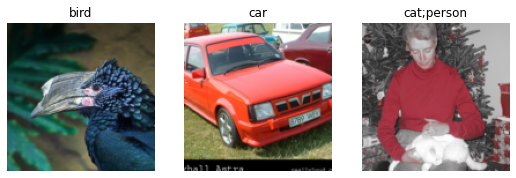

In [33]:
dls.show_batch(nrows=1, ncols=3)

DataBlockからDataLoadersを作る際に何かおかしなことが起こった場合や，DataBlockで何が起こっているのかを正確に把握したい場合には，前章で紹介したsummaryメソッドが使えることを覚えておく．

モデルを訓練するためのデータは準備できた．これから見ていくようにLearnerを作る操作は何も変わらない．しかし舞台裏では，fastaiライブラリが新たなロス関数を選択している．バイナリクロスエントロピーだ．

### 6.1.3 バイナリクロスエントロピーロス

Leanerの作成．Learnerには4つの主要な要素がある．モデル，DataLoadersオブジェクト，Optimizerオブジェクト，使用するロス関数．ここでは適切なロス関数を得る方法について焦点を当てる．

In [34]:
# cnn_learnerを使ってLearnerを作って，活性値を確認できるようにする
learn = cnn_learner(dls, resnet18)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [35]:
x, y = dls.train.one_batch()
activs = learn.model(x)
activs.shape

RuntimeError: ignored

In [65]:
activs[0]

NameError: ignored

!モデル活性値の取得

ミニバッチを手動で取得してモデルに与えて活性値とロスを知る方法を知っておくことは，モデルをデバックする上でとても重要．これは，学習にも役立つ．何が起こっているか正確に把握できるから．

これらの値はまだ0と1の間になっていないが，そうするにはsigmoid関数を使えばいい．この値に基づいてロスを計算する方法もすでに説明した．

In [63]:
def binary_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

PyTorchのようなブロードキャストと要素ごとの計算をサポートしたライブラリを使うのがうれしい理由の1つは，要素1つに対しても，要素のバッチ全体に対しても，変更なしに同じように機能するコードが書けること．関数binary_cross_entropyはこれを示す例．これらの演算を用いると，ループを書く必要がない．PyTorchが対象となるテンソルのランクに応じて適切にループしてくれる．

In [64]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

NameError: ignored

In [ ]:
def accuracy(inp, targ, axis=-1):
  """ 'targ'に対して精度を計算．'pred'のサイズはbs * n_classes """
  pred = inp.argmax(dim=axis)
  return (pred == targ).float().mean()

In [54]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
  """ 'inp'と'targ'が同じサイズであると仮定して精度を計算 """
  if sigmoid:
    inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

In [55]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'), say_hello('jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! jeremy.')

In [56]:
f = partial(say_hello, say_what="Bonjur")
f("Jeremy"), f("Sylvain")

('Bonjur Jeremy.', 'Bonjur Sylvain.')

In [57]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3, freeze_epochs=4)

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.662994,0.005709,1.000000,03:07
1,0.022081,0.003749,1.000000,03:07
2,21637.525391,0.082485,1.000000,03:06
3,180.287842,0.007021,1.000000,03:06


epoch,train_loss,valid_loss,accuracy_multi,time
0,45.044086,0.010621,1.000000,04:05
1,0.874257,0.006426,1.000000,04:04
2,0.028119,0.004894,1.000000,04:04


In [58]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.0048944284208118916,1.0]

In [59]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.0048944284208118916,0.0]

In [60]:
preds, targs = learn.get_preds()

In [61]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

In [62]:
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, ac)

NameError: ignored

### 6.2.1 データの組み立て

In [36]:
path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/22.obj'),Path('/root/.fastai/data/biwi_head_pose/07'),Path('/root/.fastai/data/biwi_head_pose/17.obj'),Path('/root/.fastai/data/biwi_head_pose/20'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/12'),Path('/root/.fastai/data/biwi_head_pose/13'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/11')...]

In [37]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00142_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00019_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00474_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00249_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00334_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00311_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00135_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00329_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00222_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00372_rgb.jpg')...]

In [39]:
# get_image_filesを使うと簡単に再帰的にすべての画像ファイルの名前を取得できる
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/07/frame_00565_pose.txt')

In [40]:
# 最初の画像を確認
im = PILImage.create(img_files[0])

In [41]:
im.shape

(480, 640)

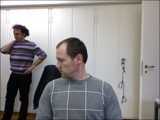

In [42]:
im.to_thumb(160)

In [43]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
  ctr = np.genfromtxt(img2pose(f), skip_header=3)
  c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
  c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
  return tensor([c1, c2])

# この関数は座標値を2つの要素を持つテンソルとして返す
get_ctr(img_files[0])

tensor([266.4682, 247.5741])

In [44]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)),
                Normalize.from_stats(*imagenet_stats)]
)

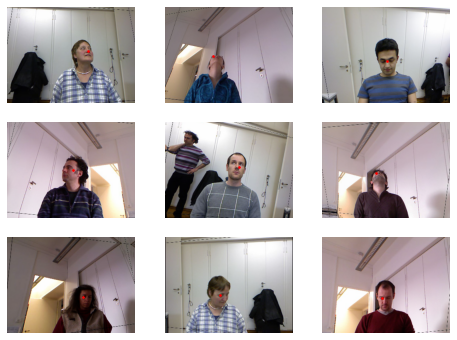

In [45]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [46]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

### 6.2.2 モデルの訓練

In [47]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [48]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

SuggestedLRs(valley=0.004365158267319202)

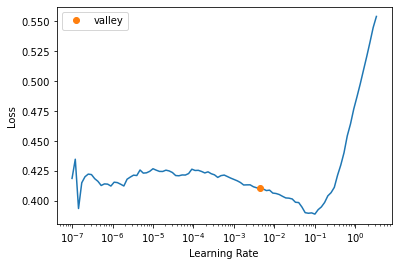

In [50]:
learn.lr_find()

In [52]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.046974,0.018984,02:10
1,0.006706,0.001118,02:05
2,0.003206,0.000442,02:02
3,0.002059,0.000213,02:02
4,0.001595,0.000484,02:01


In [53]:
math.sqrt(0.0001)

0.01

## 6.3 結論